# Raw Evaluation wrt GT

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

import pandas as pd
import os
import pprint

from evo.core.trajectory import PoseTrajectory3D
from evo.tools import plot
from evo.core import metrics
from evo.core import sync

from pose_trajectory_evaluation import PoseTrajectoryEvaluation

%reload_ext autoreload
%autoreload 2

In [256]:
##### export_path = '/mnt/data/datasets/fgsp/gt/h_floor_anymal_1/'
export_path = '/media/berlukas/Data/data/datasets/fgsp/results/v2/se3_r3_comparison_h_floor/'

n = 0

compslam_trajectories = []
gt_trajectories = []

for i in range(0, n+1):
#     compslam_traj_filename = export_path + 'compslam_spectral.npy'
    compslam_traj_filename = export_path + 'se3_with_20_constraints_and_6_scales2.npy'
    gt_traj_filename = export_path + 'gt.npy'

    compslam_trajectories.append(np.load(compslam_traj_filename))
    gt_trajectories.append(np.load(gt_traj_filename))
assert len(gt_trajectories) == len(compslam_trajectories)


print(f'Loaded {len(gt_trajectories)} missions.')
print(f'GT poses: {gt_trajectories[0].shape[0]}')
print(f'Compslam poses: {compslam_trajectories[0].shape[0]}')

Loaded 1 missions.
GT poses: 2561
Compslam poses: 3301


In [238]:
export_server_path = '/home/berlukas/Documents/results/h_floor_bkp/merged_map/'
# export_server_path = '/tmp/maplab_server/merged_map/'
csv_file = 'vertex_poses_velocities_biases.csv'
server_trajectories = []
eval = PoseTrajectoryEvaluation()

anymal_1_ms = '6b860e87b1969a160f00000000000000'
anymal_2_ms = 'ee0496a01b979a160f00000000000000'
anymal_2_ms_2 = 'ae2843fe27e69e160f00000000000000'


server_df = eval.get_mission_from_csv(export_server_path + csv_file, anymal_1_ms)
server_trajectories.append(eval.convert_df_to_traj(server_df))

print(f'Maplab poses: {server_trajectories[0].shape[0]}')

Maplab poses: 398


In [5]:
export_server_path = '/home/berlukas/Documents/results/hagerbach_july/mission_05_opt_2/'
# export_server_path = '/home/berlukas/Documents/results/icra_2022/hagerbach_anymal_2/'
csv_file = 'vertex_poses_velocities_biases.csv'
server_trajectories = []
eval = PoseTrajectoryEvaluation()

anymal_1_ms = '5b4100ac6cf495160f00000000000000'
anymal_2_ms = '970e3236aaf495160f00000000000000'
anymal_2_ms_2 = '74e2673020de9e160f00000000000000' 
anymal_5_ms = '977aa80858f595160e00000000000000'

server_df = eval.get_mission_from_csv(export_server_path + csv_file, anymal_2_ms)
server_trajectories.append(eval.convert_df_to_traj(server_df))

print(f'Maplab poses: {server_trajectories[0].shape[0]}')

Maplab poses: 2948


------------------------------------------------------

In [258]:
max_diff = 0.1

delta = 1
delta_unit = metrics.Unit.frames
all_pairs = True

# skip the first few estimates due to the darpa alignment
# compslam_trajectories[0] = compslam_trajectories[0][10:,:]
# server_trajectories[0] = server_trajectories[0][5:,:]
# server_trajectories[0] = server_trajectories[0][0:len(server_trajectories[0])-255,:]

In [257]:
gt_trajectories[0] = gt_trajectories[0][250:len(gt_trajectories[0]),:]

In [194]:
def plot_evaluations_APE(data, ape_metric, ape_stats):
    # Trajectory plot
    fig = plt.figure(figsize=(8, 6), dpi=160)
    traj_by_label = {
        "estimate": data[1],
        "reference": data[0]
    }
    plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
    plt.show()

    # Trajectory plot
    seconds_from_start = [t - data[1].timestamps[0] for t in data[1].timestamps]
    fig = plt.figure(figsize=(8, 6), dpi=160)
    plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                     statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                     name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
    plt.show()

    plot_mode = plot.PlotMode.xy
    fig = plt.figure(figsize=(8, 6), dpi=160)
    ax = plot.prepare_axis(fig, plot_mode)
    plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
    plot.traj_colormap(ax, data[1], ape_metric.error, 
                       plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
    ax.legend()
    plt.show()

def perform_evaluation_using_data(data, delta, delta_unit, all_pairs):
    print('--- Translational Part -----------------------------')
    pose_relation = metrics.PoseRelation.translation_part
    print('APE:')
    ape_metric_trans = metrics.APE(pose_relation)
    ape_metric_trans.process_data(data)
    ape_stat_trans = ape_metric_trans.get_statistic(metrics.StatisticsType.rmse)
    ape_stats_trans = ape_metric_trans.get_all_statistics()
    pprint.pprint(ape_stats_trans)

#     print('RPE:')
#     rpe_metric_trans = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
#     rpe_metric_trans.process_data(data)
#     rpe_stat_trans = rpe_metric_trans.get_statistic(metrics.StatisticsType.rmse)
#     rpe_stats_trans = rpe_metric_trans.get_all_statistics()
#     pprint.pprint(rpe_stats_trans)
#     print('\n\n')

    print('--- Rotational Part -----------------------------')
    pose_relation = metrics.PoseRelation.rotation_angle_deg
    print('APE:')
    ape_metric_rot = metrics.APE(pose_relation)
    ape_metric_rot.process_data(data)
    ape_stat_rot = ape_metric_rot.get_statistic(metrics.StatisticsType.rmse)
    ape_stats_rot = ape_metric_rot.get_all_statistics()
    pprint.pprint(ape_stats_rot)

#     print('RPE:')
#     rpe_metric_rot = metrics.RPE(pose_relation, delta, delta_unit, all_pairs)
#     rpe_metric_rot.process_data(data)
#     rpe_stat_rot = rpe_metric_rot.get_statistic(metrics.StatisticsType.rmse)
#     rpe_stats_rot = rpe_metric_rot.get_all_statistics()
#     pprint.pprint(rpe_stats_rot)

    plot_evaluations_APE(data, ape_metric_trans, ape_stats_trans)

=== COMPSLAM =========================================================
--- Translational Part -----------------------------
APE:
{'max': 1.0286474509406225,
 'mean': 0.23859016107362882,
 'median': 0.16901338797291365,
 'min': 0.003215154256311682,
 'rmse': 0.3053890456464654,
 'sse': 215.52956632318498,
 'std': 0.19062319963666224}
--- Rotational Part -----------------------------
APE:
{'max': 17.760120257622663,
 'mean': 3.153809517927482,
 'median': 2.856078680201726,
 'min': 0.18359694070369045,
 'rmse': 3.5476580122126977,
 'sse': 29085.96260580677,
 'std': 1.6246116139702347}


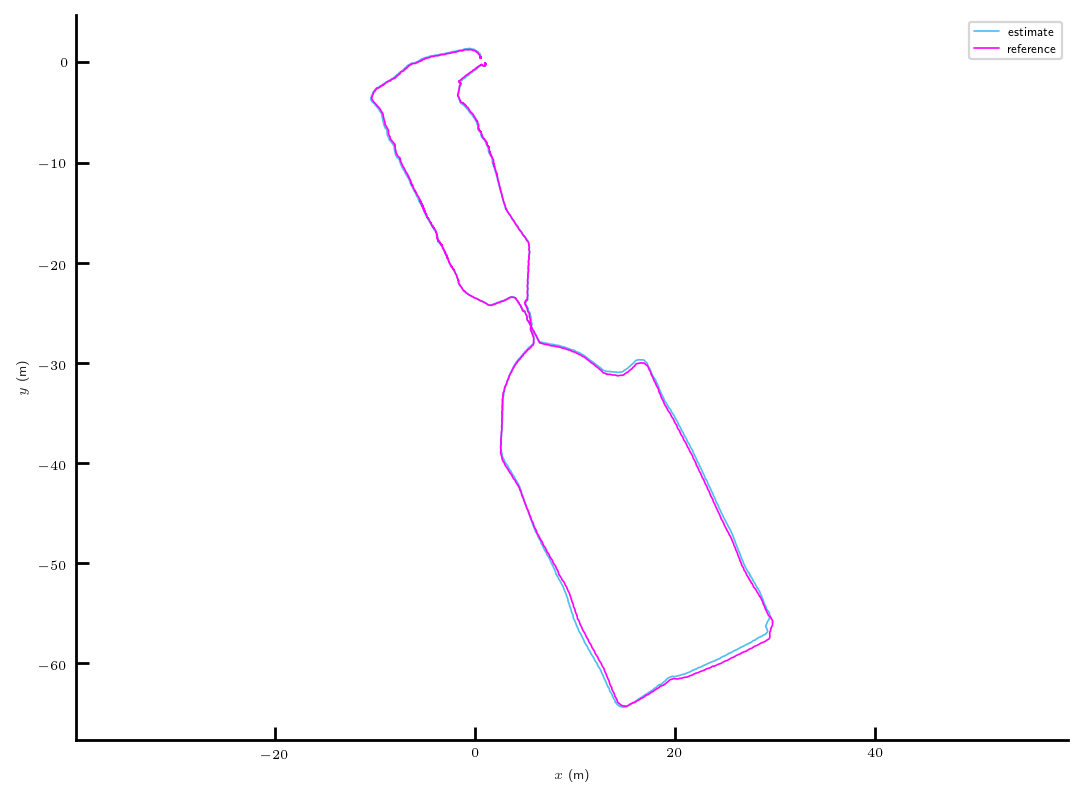

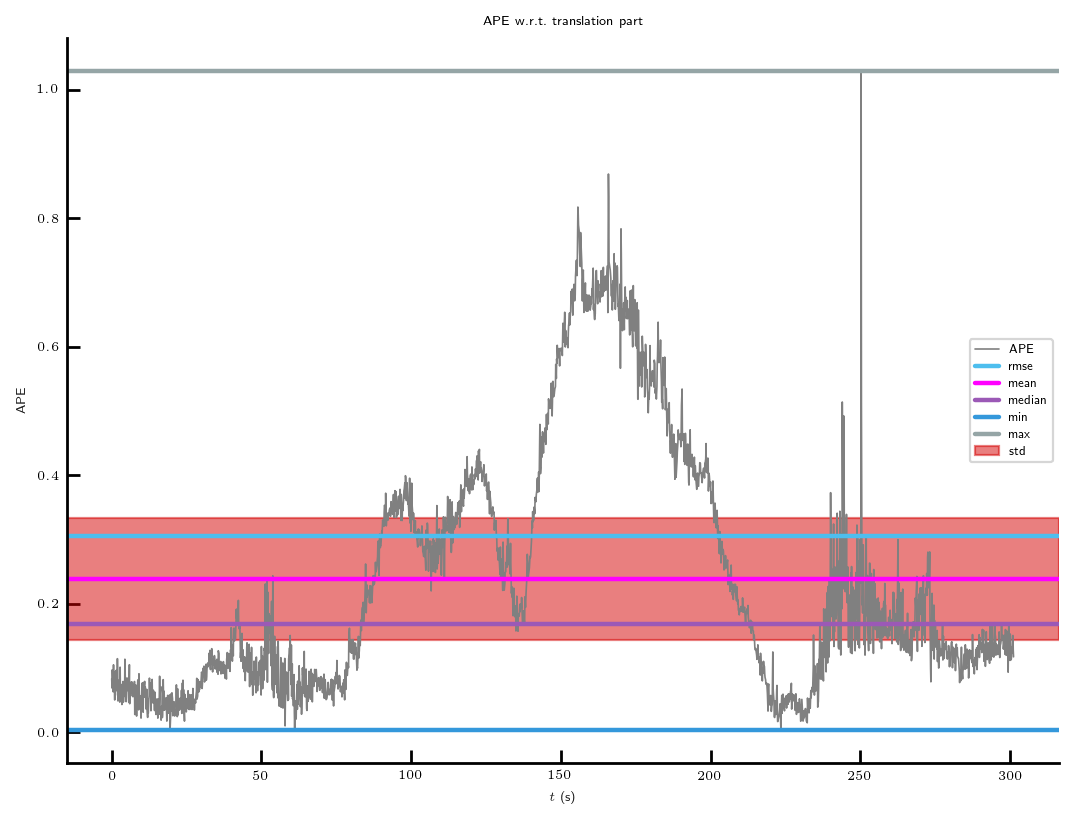

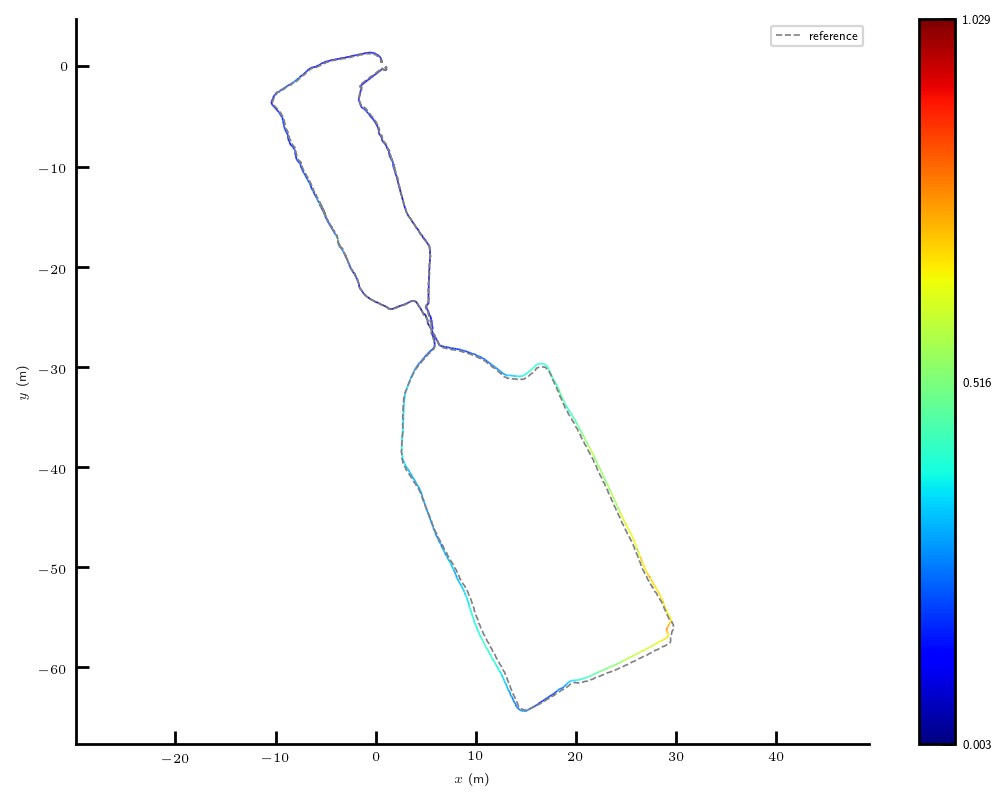

=== Maplab ===========================================================
--- Translational Part -----------------------------
APE:
{'max': 0.5600698914813621,
 'mean': 0.18993177553356394,
 'median': 0.14948457736272958,
 'min': 0.01060872242718655,
 'rmse': 0.21757230366593025,
 'sse': 17.60962712396991,
 'std': 0.1061302405781107}
--- Rotational Part -----------------------------
APE:
{'max': 16.621935659710218,
 'mean': 3.2256864908250273,
 'median': 3.0561558027554403,
 'min': 1.0670126158812814,
 'rmse': 3.533037769009797,
 'sse': 4643.436386336896,
 'std': 1.4412850308522056}


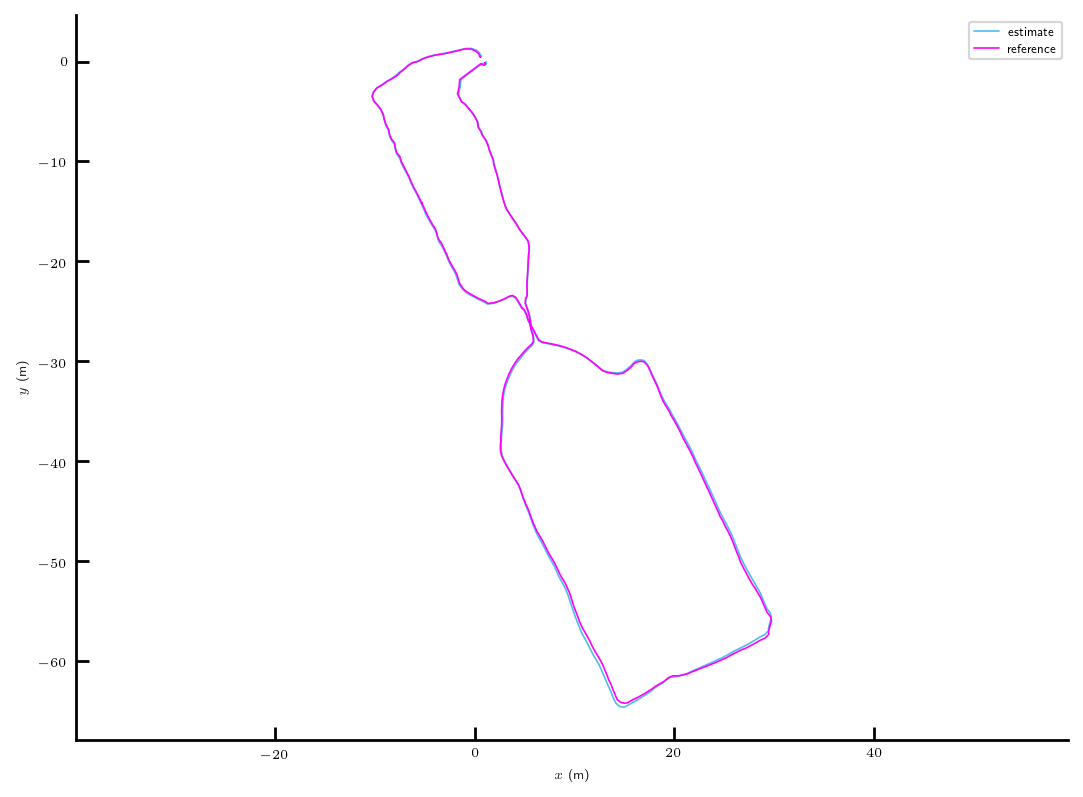

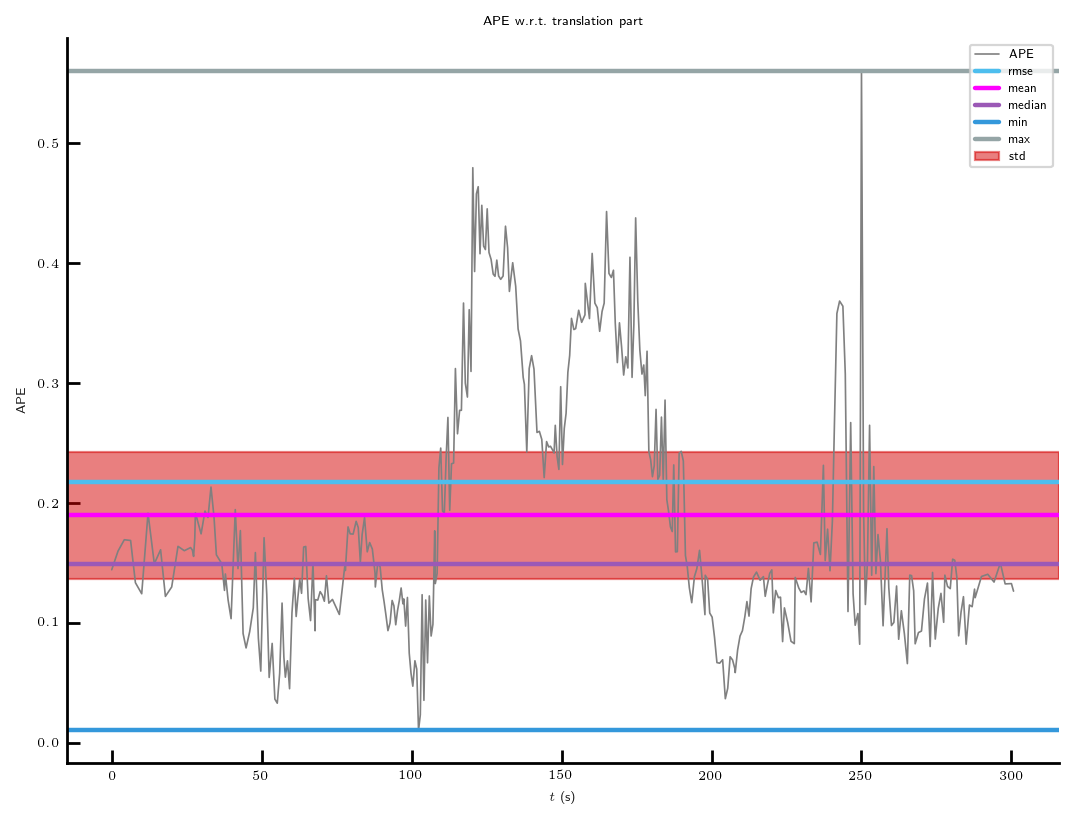

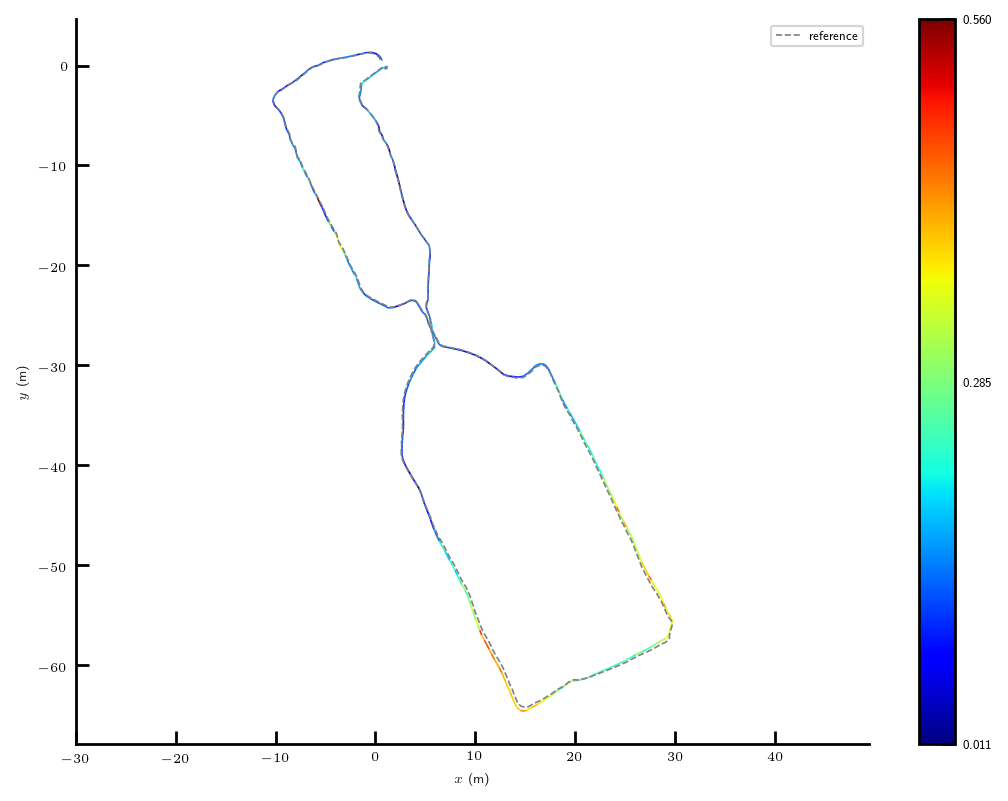

In [259]:
idx = 0

def ts_ns_to_seconds(ts_ns):
    k_ns_per_s = 1e9;
    return ts_ns / k_ns_per_s;

def convert_to_traj(trajectory):
    ts = ts_ns_to_seconds(trajectory[:,0])
    xyz = trajectory[:,1:4]
#     xyz = np.zeros((trajectory.shape[0],3))
#     xyz[:,0:2] = trajectory[:,1:3]
    wxyz = trajectory[:,4:8]
    return PoseTrajectory3D(positions_xyz = xyz, orientations_quat_wxyz = wxyz, timestamps = ts)

print(f'=== COMPSLAM =========================================================')
compslam_traj = convert_to_traj(compslam_trajectories[idx])
gt_traj = convert_to_traj(gt_trajectories[idx])
gt_traj, compslam_traj = sync.associate_trajectories(gt_traj, compslam_traj, max_diff)
compslam_traj.align(gt_traj, correct_scale=False, correct_only_scale=False, n=600)
data = (gt_traj, compslam_traj)
perform_evaluation_using_data(data, delta, delta_unit, all_pairs)


print(f'=== Maplab ===========================================================')
server_traj = convert_to_traj(server_trajectories[idx])
gt_traj = convert_to_traj(gt_trajectories[idx])
gt_traj, server_traj = sync.associate_trajectories(gt_traj, server_traj, max_diff)
server_traj.align(gt_traj, correct_scale=False, correct_only_scale=False, n=600)

data = (gt_traj, server_traj)
perform_evaluation_using_data(data, delta, delta_unit, all_pairs)

In [30]:
test = np.column_stack((gt_traj.timestamps, gt_traj.positions_xyz, gt_traj.orientations_quat_wxyz))
test.shape

(397, 8)